In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-03-BIGDATA/master/init.py
import init; init.init(force_download=False); 
from IPython.display import Image

replicating local resources


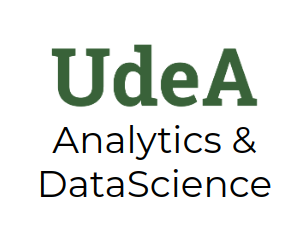

In [ ]:
Image("local/imgs/udea-datascience.png")

In [ ]:
#Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz 
!tar xf spark-3.0.1-bin-hadoop3.2.tgz 
!pip install -q findspark

#Variables de Entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

#SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

#**DATA FRAME**

Se puede definir como una colección de datos distribuidos organizada por columnas y optimizada para para operar en clústers de Spark

Es un concepto similar a las tablas en las bases de datos relacionales solo que presentan características similares a los RDDs

En los Data Frames se puede acceder a los datos utilizando la librería SQL de Spark a través del SQLContext que se obtiene desde el SparkContext


In [ ]:
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)

**Crear un Data Frame**

Existen dos formas de crear un Data Frame

1. Desde un RDD: Crear un RDD y usar el método createDataFrame para obtener un Data Frame a partir del RDD

In [ ]:
datos=[(1,"Juan",33,"Masculino","Ingeniero",4500000),\
       (2,"Ana",38,"Femenino","Arquitecta",6200000),\
       (3,"Carmen",52,"Femenino","Abogada",7500000)]
empleadosRDD=sc.parallelize(datos)
empleadosRDD.collect()

[(1, 'Juan', 33, 'Masculino', 'Ingeniero', 4500000),
 (2, 'Ana', 38, 'Femenino', 'Arquitecta', 6200000),
 (3, 'Carmen', 52, 'Femenino', 'Abogada', 7500000)]

In [ ]:
type(empleadosRDD)


pyspark.rdd.RDD

In [ ]:
empleadosDF=sqlCtx.createDataFrame(empleadosRDD)
empleadosDF.collect()

[Row(_1=1, _2='Juan', _3=33, _4='Masculino', _5='Ingeniero', _6=4500000),
 Row(_1=2, _2='Ana', _3=38, _4='Femenino', _5='Arquitecta', _6=6200000),
 Row(_1=3, _2='Carmen', _3=52, _4='Femenino', _5='Abogada', _6=7500000)]

In [ ]:
type(empleadosDF)

pyspark.sql.dataframe.DataFrame

Los Data Frame tiene algunos métodos que facilitan la operación y visualización de los datos

> Bloc con sangría



In [ ]:
empleadosDF.show()

+---+------+---+---------+----------+-------+
| _1|    _2| _3|       _4|        _5|     _6|
+---+------+---+---------+----------+-------+
|  1|  Juan| 33|Masculino| Ingeniero|4500000|
|  2|   Ana| 38| Femenino|Arquitecta|6200000|
|  3|Carmen| 52| Femenino|   Abogada|7500000|
+---+------+---+---------+----------+-------+



Para comprender mejor los datos podemos indicar el nombre de las columnas

In [ ]:
empleadosDF=sqlCtx.createDataFrame(empleadosRDD,["Id","Nombre","Edad","Sexo","Profesión","Salario"])
empleadosDF.collect()

[Row(Id=1, Nombre='Juan', Edad=33, Sexo='Masculino', Profesión='Ingeniero', Salario=4500000),
 Row(Id=2, Nombre='Ana', Edad=38, Sexo='Femenino', Profesión='Arquitecta', Salario=6200000),
 Row(Id=3, Nombre='Carmen', Edad=52, Sexo='Femenino', Profesión='Abogada', Salario=7500000)]

In [ ]:
empleadosDF.show()

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
+---+------+----+---------+----------+-------+



Veamos qué tipo de dato se adoptó para cada variable

In [ ]:
empleadosDF.printSchema()

root
 |-- Id: long (nullable = true)
 |-- Nombre: string (nullable = true)
 |-- Edad: long (nullable = true)
 |-- Sexo: string (nullable = true)
 |-- Profesión: string (nullable = true)
 |-- Salario: long (nullable = true)



En el siguiente link puede consultar los diferentes tipos de datos disponibles


http://spark.apache.org/docs/3.0.0-preview2/sql-ref-datatypes.html


La Edad y el salario los estamos usando con el mismo tipo de dato, pero en realidad podríamos optimizar si modificamos el tipo de dato de la edad

In [ ]:
from pyspark.sql.types import *
empleadosDF=sqlCtx.createDataFrame(empleadosRDD, \
          StructType([ \
                      StructField("Id", ByteType(),False), \
                      StructField("Nombre", StringType(),False), \
                      StructField("Edad", ByteType(),False), \
                      StructField("Sexo", StringType(),False), \
                      StructField("Profesión", StringType(),False), \
                      StructField("Salario", IntegerType(),False)]))

In [ ]:
empleadosDF.printSchema()
empleadosDF.show()

root
 |-- Id: byte (nullable = false)
 |-- Nombre: string (nullable = false)
 |-- Edad: byte (nullable = false)
 |-- Sexo: string (nullable = false)
 |-- Profesión: string (nullable = false)
 |-- Salario: integer (nullable = false)

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
+---+------+----+---------+----------+-------+



2. Crear Data Frame desde un archivo externo

**Cargar archivo csv**

In [ ]:
empleadosDF = sqlCtx.read.csv("local/data/empleados.csv")
type(empleadosDF)

pyspark.sql.dataframe.DataFrame

In [ ]:
datempleadosDFa.show(5)

+---+------+----+---------+----------+-------+
|_c0|   _c1| _c2|      _c3|       _c4|    _c5|
+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesi�n|Salario|
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
+---+------+----+---------+----------+-------+



Creo el Data Frame correctamente pero no le hemos indicado que la primera línea es el header

In [ ]:
empleadosDF = sqlCtx.read.option("header",True) \
     .csv("local/data/empleados.csv")
empleadosDF.show(5)

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesi�n|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
+---+------+----+---------+----------+-------+



Veamos el formato asumido para cada variable

In [ ]:
empleadosDF.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Nombre: string (nullable = true)
 |-- Edad: string (nullable = true)
 |-- Sexo: string (nullable = true)
 |-- Profesi�n: string (nullable = true)
 |-- Salario: string (nullable = true)



Qué tal si asignamos el tipo de datos de cada variable

In [ ]:
schema = StructType() \
      .add("Id",ByteType(),True) \
      .add("Nombre",StringType(),True) \
      .add("Edad",ByteType(),True) \
      .add("Sexo",StringType(),True) \
      .add("Profesión",StringType(),True) \
      .add("Salario",IntegerType(),True)


In [ ]:
empleadosDF = sqlCtx.read.format("csv") \
      .option("header", True) \
      .option("delimiter", ",") \
      .schema(schema) \
      .load("local/data/empleados.csv")

In [ ]:
empleadosDF.printSchema()
empleadosDF.show()

root
 |-- Id: byte (nullable = true)
 |-- Nombre: string (nullable = true)
 |-- Edad: byte (nullable = true)
 |-- Sexo: string (nullable = true)
 |-- Profesión: string (nullable = true)
 |-- Salario: integer (nullable = true)

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
+---+------+----+---------+----------+-------+



**Cargar archivo json**

In [ ]:
empleadosDF = sqlCtx.read.json("local/data/empleados.json")
type(empleadosDF)

pyspark.sql.dataframe.DataFrame

In [ ]:
empleadosDF.printSchema()
empleadosDF.show()

root
 |-- Edad: long (nullable = true)
 |-- Id: long (nullable = true)
 |-- Nombre: string (nullable = true)
 |-- Profesión: string (nullable = true)
 |-- Salario: long (nullable = true)
 |-- Sexo: string (nullable = true)

+----+---+------+----------+-------+---------+
|Edad| Id|Nombre| Profesión|Salario|     Sexo|
+----+---+------+----------+-------+---------+
|  33|  1|  Juan| Ingeniero|4500000|Masculino|
|  38|  2|   Ana|Arquitecta|6200000| Femenino|
+----+---+------+----------+-------+---------+



In [ ]:
empleadosDF = sqlCtx.read.json("local/data/empleados.json", \
            StructType([ \
                      StructField("Id", IntegerType(),False), \
                      StructField("Nombre", StringType(),False), \
                      StructField("Edad", ByteType(),False), \
                      StructField("Sexo", StringType(),False), \
                      StructField("Profesión", StringType(),False), \
                      StructField("Salario", IntegerType(),False)]))
type(empleadosDF)

pyspark.sql.dataframe.DataFrame

In [ ]:
empleadosDF.printSchema()
empleadosDF.show()

root
 |-- Id: integer (nullable = true)
 |-- Nombre: string (nullable = true)
 |-- Edad: byte (nullable = true)
 |-- Sexo: string (nullable = true)
 |-- Profesión: string (nullable = true)
 |-- Salario: integer (nullable = true)

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
+---+------+----+---------+----------+-------+



**Acceso a los datos**

Una gran ventaja que ofrecen los Data Frames es que podemos acceder a cada variable a través del nombre del data frame, el caracter punto(.) y el nombre de la variable

In [ ]:
empleadosDF.Salario

Column<b'Salario'>

##**Operaciones**

Sobre los Data Frames podemos realizar varios tipos de operaciones.

Vamos dos de ellas, a saber, propiedades y métodos

###**Propiedades**

Las propiedades son atributos que podemos consultar sobre nuestros Data Frames.

Veamos algunas de ellas

**columns**

Es una propiedad que se utiliza para conocer el nombre de las variables (columnas) del Data Frame

In [ ]:
empleadosDF.columns

['Id', 'Nombre', 'Edad', 'Sexo', 'Profesión', 'Salario']

**dtypes**

Atributo que indica el tipo de dato de cada variable (columna) del Data Frame

In [ ]:
empleadosDF.dtypes

[('Id', 'bigint'),
 ('Nombre', 'string'),
 ('Edad', 'bigint'),
 ('Sexo', 'string'),
 ('Profesión', 'string'),
 ('Salario', 'bigint')]

**rdd**

Convierte un Data Frame a un RDD

In [ ]:
empRDD=empleadosDF.rdd
type(empRDD)


pyspark.rdd.RDD

###**Métodos**

Data Frame dispone de una serie de métodos que podemos aplicar sobre nuestros datos. Algunos de estos son similares a los métodos revisados para RDD.

Veamos algunos de los principales métodos disponibles en Data Frames

**agg(funciones_agregacion)**

Este método realiza una agregación sobre el data frame, es decir que a partir del data frame original, devuelve un nuevo data frame que contiene el resultado de las funciones de agregación realizadas sobre el conjunto de datos.

Estas funciones de agregación son especificadas por el usuario y hacen referencia a operaciones básicas sobre los datos. Estas son algunas de las funciones de agregación disponibles:

* first: entrega el primer elemento
* last: entrega el último elemento
* min: entrega el valor mínimo de una variable específica
* max: entrega el valor máximo de una variable específica
* sum: entrega la suma de los valores de una variable específica
* avg: entrega el promedio de los valores de una variable específica

Usemos el método agg para conocer el promedio de los salarios de los empleados

---



In [ ]:
salario=empleadosDF.agg({"Salario": "avg"})
salario.show()

+-----------------+
|     avg(Salario)|
+-----------------+
|6066666.666666667|
+-----------------+



In [ ]:
type(salario)

pyspark.sql.dataframe.DataFrame

También podemos utilizar las funciones disponibles en la clase functions de la librería pyspark.sql 

In [ ]:
from pyspark.sql import functions
edad=empleadosDF.agg( \
    functions.min(empleadosDF.Edad), \
    functions.max(empleadosDF.Edad), \
    functions.avg(empleadosDF.Edad))
edad.show()

+---------+---------+---------+
|min(Edad)|max(Edad)|avg(Edad)|
+---------+---------+---------+
|       33|       52|     41.0|
+---------+---------+---------+



En este caso utilizamos tres funciones de agregación, el resultado es un nuevo Data Frame de una sola fila y tres columnas (una por cada función de agregación)

**corr(var1,var2)**

Este método se utiliza para calcular la correlación entre un par de variables del Data Frame

In [ ]:
empleadosDF.corr("Edad", "Salario")

0.9414864645748744

**count()**

Se utiliza para conocer el número de registros (filas) en el Data Frame

In [ ]:
empleadosDF.count()

3

**distinct()**

Crea un nuevo Data Frame a partir de los registros (filas) que sean diferentes en el Data Frame inicial

In [ ]:
emp=empleadosDF.distinct()
emp.show()

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
+---+------+----+---------+----------+-------+



**drop(var)**

Toma el Data Frame inicial, elimina la variable (columna) especificada y entrega un nuevo Data Frame con el resultado

In [ ]:
emp=empleadosDF.drop("Id")
emp.show()

+------+----+---------+----------+-------+
|Nombre|Edad|     Sexo| Profesión|Salario|
+------+----+---------+----------+-------+
|  Juan|  33|Masculino| Ingeniero|4500000|
|   Ana|  38| Femenino|Arquitecta|6200000|
|Carmen|  52| Femenino|   Abogada|7500000|
+------+----+---------+----------+-------+



**union(other)**

Este método crea un nuevo Data Frame a partir de la unión de dos Data Frames

In [ ]:
nuevos=sqlCtx.createDataFrame([ \
      (4,"Ana",40,"Femenino","Docente",7600000), \
      (5,"Luis",62,"Masculino","Panadero",None)])
ana.show()

+---+---+---+--------+-------+-------+
| _1| _2| _3|      _4|     _5|     _6|
+---+---+---+--------+-------+-------+
|  4|Ana| 40|Femenino|Docente|7600000|
+---+---+---+--------+-------+-------+



In [ ]:
emp=empleadosDF.union(nuevos)
emp.show()

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
|  4|   Ana|  40| Femenino|   Docente|7600000|
|  5|  Luis|  62|Masculino|  Panadero|   null|
+---+------+----+---------+----------+-------+



**dropDuplicates(var)**

Este método devuelve un nuevo Data Frame en el que ha eliminado los registros (filas) duplicadas. Esto ya los hacía el método distinct(), la diferencia es que en dropDuplicates() se puede especificar las columnas a evaluar para considerar que dos registros son duplicados

In [ ]:
empd=emp.dropDuplicates(["Nombre","Sexo"])
empd.show()

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
|  5|  Luis|  62|Masculino|  Panadero|   null|
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
+---+------+----+---------+----------+-------+



**fillna(valor,col[ ])**

Este método devuelve un nuevo Data Frame luego de sustituir los valores nulos detectados por el valor especificado.

Adicionalmente, es posible indicarlo cuales son las columnas sobre las que va a operar

In [ ]:
empfna=empd.fillna(1000000)
empfna.show()

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
|  5|  Luis|  62|Masculino|  Panadero|1000000|
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
+---+------+----+---------+----------+-------+



**dropna(_cuantas, _umbral, _columnas)**

Este método devuelve un nuevo Dat Frame resultado de eliminar los registros (filas) que contienen nulos en el Data Frame inicial.



In [ ]:
empd.show()

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
|  5|  Luis|  62|Masculino|  Panadero|   null|
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
+---+------+----+---------+----------+-------+



In [ ]:
empdna=empd.dropna("any")
empdna.show()

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
+---+------+----+---------+----------+-------+



**filter(condicion)**

Funciona similar al filter de RDD. Devuelve un nuevo Data Frame que contiene los registros para los cuales la condición arroja como resultado True

In [ ]:
empf=empleadosDF.filter(empleadosDF.Salario>5000000)
empleadosDF.show()
empf.show()

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
+---+------+----+---------+----------+-------+

+---+------+----+--------+----------+-------+
| Id|Nombre|Edad|    Sexo| Profesión|Salario|
+---+------+----+--------+----------+-------+
|  2|   Ana|  38|Femenino|Arquitecta|6200000|
|  3|Carmen|  52|Femenino|   Abogada|7500000|
+---+------+----+--------+----------+-------+



**GroupBy(var)**

Genera un nuevo Data Frame donde agrupa los registros que coincidan en la variable especificada. 

Luego de agrupar es posible realizar agregaciones para indicar que se desea realizar con los valores de los registros agrupados


In [ ]:
empavg=emp.groupBy("Nombre").avg()
empsal=emp.groupBy("Nombre").agg({"Salario":"avg"})
print("Data Frame Inicial")
emp.show()
print("Data Frame promediando todas las variables")
empavg.show()
print("Data Frame promediando una variable específica")
empsal.show()

Data Frame Inicial
+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
|  4|   Ana|  40| Femenino|   Docente|7600000|
|  5|  Luis|  62|Masculino|  Panadero|   null|
+---+------+----+---------+----------+-------+

Data Frame promediando todas las variables
+------+-------+---------+------------+
|Nombre|avg(Id)|avg(Edad)|avg(Salario)|
+------+-------+---------+------------+
|Carmen|    3.0|     52.0|   7500000.0|
|   Ana|    3.0|     39.0|   6900000.0|
|  Luis|    5.0|     62.0|        null|
|  Juan|    1.0|     33.0|   4500000.0|
+------+-------+---------+------------+

Data Frame promediando una variable específica
+------+------------+
|Nombre|avg(Salario)|
+------+------------+
|Carmen|   7500000.0|
|   Ana|   6900000.0|
|  Luis|        null|
|  Juan|   450

**orderBy(var)**

Entrega un Data Frame ordenado de acuerdo a la variable indicada

In [ ]:
empo=emp.orderBy(emp.Salario.desc())
print("Data Frame Inicial")
emp.show()
print("Data Frame ordebado por salario")
empo.show()

Data Frame Inicial
+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
|  4|   Ana|  40| Femenino|   Docente|7600000|
|  5|  Luis|  62|Masculino|  Panadero|   null|
+---+------+----+---------+----------+-------+

Data Frame ordebado por salario
+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  4|   Ana|  40| Femenino|   Docente|7600000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  5|  Luis|  62|Masculino|  Panadero|   null|
+---+------+----+---------+----------+-------+



**select(lista_var)**

Genera un nuevo Data Frame que incluye únicamente las variables indicadas del Data Frame original

In [ ]:
emps=empleadosDF.select("Nombre","Sexo","Salario")
print("Data Frame Inicial")
empleadosDF.show()
print("Data Frame nuevo")
emps.show()

Data Frame Inicial
+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
+---+------+----+---------+----------+-------+

Data Frame nuevo
+------+---------+-------+
|Nombre|     Sexo|Salario|
+------+---------+-------+
|  Juan|Masculino|4500000|
|   Ana| Femenino|6200000|
|Carmen| Femenino|7500000|
+------+---------+-------+



**selectExpr(expresiones)**

Funciona similar al método select(), pero permite crear nuevas variables (columnas) a partir de la evaluación de las expresiones indicadas

In [ ]:
emps=empleadosDF.selectExpr("Nombre","Sexo","Salario", "Edad > 50")
print("Data Frame Inicial")
empleadosDF.show()
print("Data Frame nuevo")
emps.show()

Data Frame Inicial
+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
+---+------+----+---------+----------+-------+

Data Frame nuevo
+------+---------+-------+-----------+
|Nombre|     Sexo|Salario|(Edad > 50)|
+------+---------+-------+-----------+
|  Juan|Masculino|4500000|      false|
|   Ana| Femenino|6200000|      false|
|Carmen| Femenino|7500000|       true|
+------+---------+-------+-----------+



**withcolumn(nombre,expresion)**

Al igual que selectExpr() permite adicionar columnas con el resultado de la evaluación de una expresión. La diferencia consiste en poder asignar el nombre de las columnas adicionadas

In [ ]:
emps=empleadosDF.withColumn("Mayor de 50", empleadosDF.Edad > 50)
print("Data Frame Inicial")
empleadosDF.show()
print("Data Frame nuevo")
emps.show()

Data Frame Inicial
+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
+---+------+----+---------+----------+-------+

Data Frame nuevo
+---+------+----+---------+----------+-------+-----------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|Mayor de 50|
+---+------+----+---------+----------+-------+-----------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|      false|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|      false|
|  3|Carmen|  52| Femenino|   Abogada|7500000|       true|
+---+------+----+---------+----------+-------+-----------+



##**Consultas SQL**

Los métodos descritos anteriormente permiten operar los datos para crear registros, leerlos, actualizarlos e incluso eliminarlos, las operaciones básicas de un CRUD.

Seguramente usted está acostumbrado a realizar estas operaciones utilizando lenguaje SQL, pues bien, la clase SqlContext de Spark cuenta con un método llamado sql que permite utilizar el lenguaje SQL para operar un Data Frame

Para poder hacer esto, debe registrar en el motor de SQL una tabla que servirá para referenciar el Data Frame y realizar las operaciones sobre dicha tabla

In [ ]:
empleadosDF.registerTempTable("Empleados")

NameError: ignored

De esta manera cada que requiere utilizar una consulta SQL lo realizará sobre la tabla Empleados

**Lectura de datos**

In [ ]:
q1 = sqlCtx.sql("SELECT * FROM Empleados")
q1.show()

+---+------+----+---------+----------+-------+
| Id|Nombre|Edad|     Sexo| Profesión|Salario|
+---+------+----+---------+----------+-------+
|  1|  Juan|  33|Masculino| Ingeniero|4500000|
|  2|   Ana|  38| Femenino|Arquitecta|6200000|
|  3|Carmen|  52| Femenino|   Abogada|7500000|
+---+------+----+---------+----------+-------+



**Filtremos los registros que la edad sea mayor que 50**

In [ ]:
q2 = sqlCtx.sql('SELECT * FROM Empleados WHERE Edad >50')
q2.show()

+---+------+----+--------+---------+-------+
| Id|Nombre|Edad|    Sexo|Profesión|Salario|
+---+------+----+--------+---------+-------+
|  3|Carmen|  52|Femenino|  Abogada|7500000|
+---+------+----+--------+---------+-------+



**Leamos solo las variables de interés**

In [ ]:
q3 = sqlCtx.sql("""
		SELECT Nombre, Edad, Sexo 
		FROM Empleados
	""")
q3.show()

+------+----+---------+
|Nombre|Edad|     Sexo|
+------+----+---------+
|  Juan|  33|Masculino|
|   Ana|  38| Femenino|
|Carmen|  52| Femenino|
+------+----+---------+



**Funciones definidas por el usuario**

A demás de las consultas básicas que proporciona SQL, el usuario puede definir sus propias funciones e incorporarlas dentro de una consulta SQL. Esto es de gran ayuda para personalizar las acciones que deseamos realizar sobre los datos

Primero debemos definir la función a utilizar

In [ ]:
def funcionEdad(edad):
	if edad < 50:
		return "Menor de 50"
	else:
		return "Mayor de 50"


Ahora debemos registrar la función con la ayuda del SqlContext

In [ ]:
sqlCtx.registerFunction("funcionEdad",funcionEdad)


<function __main__.funcionEdad>

Ahora si podemos empezar a usar nuestra función

In [ ]:
q4 = sqlCtx.sql("""
		SELECT Nombre, Sexo, Salario, funcionEdad(Edad) AS Edad_Mayor_50
		FROM Empleados
		""")
q4.show()

+------+---------+-------+-------------+
|Nombre|     Sexo|Salario|Edad_Mayor_50|
+------+---------+-------+-------------+
|  Juan|Masculino|4500000|  Menor de 50|
|   Ana| Femenino|6200000|  Menor de 50|
|Carmen| Femenino|7500000|  Mayor de 50|
+------+---------+-------+-------------+



#**Ejemplos**

##**Titanic**

El archivo titanic.csv recoge la información de los 2201 pasajeros del titanic. Para cada pasajero se dispone de la siguiente información.

* Clase: Tripulación, Primera, Segunda, Tercera
* Edad: Adulto, Niño
* Sexo: Hombre, Mujer
* Sobrevivió: Si, No

Creemos un Data Frame a partir de este archivo y realicemos algunas operaciones

In [ ]:
titanic = sqlCtx.read.option("header",True) \
      .option("delimiter",";") \
     .csv("local/data/titanic.csv")
titanic.show(5)

+-------+------+------+----------+
|  Clase|  Edad|  Sexo|Sobrevivio|
+-------+------+------+----------+
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
+-------+------+------+----------+
only showing top 5 rows



**Cuántos pasajeros sobrevivieron por clase?**

In [ ]:
sob=titanic.filter(titanic.Sobrevivio=="Si")
sob.distinct().show()

+-----------+------+------+----------+
|      Clase|  Edad|  Sexo|Sobrevivio|
+-----------+------+------+----------+
|    Primera|Adulto|Hombre|        Si|
|    Segunda|Adulto| Mujer|        Si|
|    Tercera|Adulto| Mujer|        Si|
|    Primera|Adulto| Mujer|        Si|
|    Segunda|  Ni�o| Mujer|        Si|
|    Tercera|  Ni�o|Hombre|        Si|
|    Primera|  Ni�o| Mujer|        Si|
|Tripulacion|Adulto| Mujer|        Si|
|    Segunda|Adulto|Hombre|        Si|
|    Primera|  Ni�o|Hombre|        Si|
|    Tercera|Adulto|Hombre|        Si|
|Tripulacion|Adulto|Hombre|        Si|
|    Segunda|  Ni�o|Hombre|        Si|
|    Tercera|  Ni�o| Mujer|        Si|
+-----------+------+------+----------+



In [ ]:
sob1=sob.filter(sob.Clase=="Primera")
sob1.count()

203

In [ ]:
cs1=titanic.filter(titanic.Sobrevivio=="Si").filter(titanic.Clase=="Primera").count()
cs2=titanic.filter(titanic.Sobrevivio=="Si").filter(titanic.Clase=="Segunda").count()
cs3=titanic.filter(titanic.Sobrevivio=="Si").filter(titanic.Clase=="Tercera").count()
cst=titanic.filter(titanic.Sobrevivio=="Si").filter(titanic.Clase=="Tripulacion").count()

print("Los sobrevivientes de primera clase son : ",cs1)
print("Los sobrevivientes de segunda clase son : ",cs2)
print("Los sobrevivientes de tercera clase son : ",cs3)
print("Los sobrevivientes de la tripulación son : ",cst)



Los sobrevivientes de primera clase son :  203
Los sobrevivientes de segunda clase son :  118
Los sobrevivientes de tercera clase son :  178
Los sobrevivientes de la tripulación son :  212


Y cómo contamos los que no sobrevivieron?

In [ ]:
ns1=titanic.filter(titanic.Sobrevivio=="No").filter(titanic.Clase=="Primera").count()
ns2=titanic.filter(titanic.Sobrevivio=="No").filter(titanic.Clase=="Segunda").count()
ns3=titanic.filter(titanic.Sobrevivio=="No").filter(titanic.Clase=="Tercera").count()
nst=titanic.filter(titanic.Sobrevivio=="No").filter(titanic.Clase=="Tripulacion").count()

print("Los que NO sobrevivieron de primera clase son : ",ns1)
print("Los que NO sobrevivieron de segunda clase son : ",ns2)
print("Los que NO sobrevivieron de tercera clase son : ",ns3)
print("Los que NO sobrevivieron de la tripulación son : ",nst)

Los que NO sobrevivieron de primera clase son :  122
Los que NO sobrevivieron de segunda clase son :  167
Los que NO sobrevivieron de tercera clase son :  528
Los que NO sobrevivieron de la tripulación son :  673


Calculemos el promedio

In [ ]:
print("Promedio de sobrevivientes por clase")
print("Primera clase : ",round((cs1*100)/(cs1+ns1),1))
print("Segunda clase : ",round((cs2*100)/(cs2+ns2),1))
print("Tercera clase : ",round((cs3*100)/(cs3+ns3),1))
print("Tripulación :   ",round((cst*100)/(cst+nst),1))

Promedio de sobrevivientes por clase
Primera clase :  62.5
Segunda clase :  41.4
Tercera clase :  25.2
Tripulación :    24.0


Veamos otra forma de resolverlo

In [ ]:
titanic.registerTempTable("Titanic")
q = sqlCtx.sql("SELECT * FROM Titanic")
q.show(5)

+-------+------+------+----------+
|  Clase|  Edad|  Sexo|Sobrevivio|
+-------+------+------+----------+
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
|Primera|Adulto|Hombre|        Si|
+-------+------+------+----------+
only showing top 5 rows



In [ ]:
titanic.registerTempTable("Titanic")
q = sqlCtx.sql("SELECT Clase, Sobrevivio FROM Titanic")
q.distinct().show()

+-----------+----------+
|      Clase|Sobrevivio|
+-----------+----------+
|    Primera|        Si|
|    Tercera|        Si|
|    Segunda|        Si|
|    Segunda|        No|
|Tripulacion|        No|
|    Primera|        No|
|    Tercera|        No|
|Tripulacion|        Si|
+-----------+----------+



In [ ]:
def SobrevivioInt(sobrevivio):
		return int (sobrevivio=="Si")

In [ ]:
sqlCtx.registerFunction("SobrevivioInt",SobrevivioInt)

<function __main__.SobrevivioInt>

In [ ]:
sob = sqlCtx.sql("""
		SELECT Clase, SobrevivioInt(Sobrevivio) AS Sobrevivio
		FROM Titanic
		""")
sob.distinct().show()

+-----------+----------+
|      Clase|Sobrevivio|
+-----------+----------+
|Tripulacion|         1|
|    Primera|         0|
|    Segunda|         1|
|    Tercera|         1|
|    Segunda|         0|
|    Tercera|         0|
|Tripulacion|         0|
|    Primera|         1|
+-----------+----------+



In [ ]:
sob.printSchema()

root
 |-- Clase: string (nullable = true)
 |-- Sobrevivio: string (nullable = true)



In [ ]:
from pyspark.sql import functions
from pyspark.sql.types import *
sobInt=sob.withColumn("Sobrevivio",sob.Sobrevivio.cast(ByteType()))
sobInt.printSchema()


root
 |-- Clase: string (nullable = true)
 |-- Sobrevivio: byte (nullable = true)



In [ ]:
sobClase=sobInt.groupBy('Clase').sum().show()

+-----------+---------------+
|      Clase|sum(Sobrevivio)|
+-----------+---------------+
|    Tercera|            178|
|    Segunda|            118|
|    Primera|            203|
|Tripulacion|            212|
+-----------+---------------+



In [ ]:
totalClase=sobInt.groupBy('Clase').count().show()

+-----------+-----+
|      Clase|count|
+-----------+-----+
|    Tercera|  706|
|    Segunda|  285|
|    Primera|  325|
|Tripulacion|  885|
+-----------+-----+



In [ ]:
promSobClase=sobInt.groupBy('Clase').avg().show()

+-----------+-------------------+
|      Clase|    avg(Sobrevivio)|
+-----------+-------------------+
|    Tercera| 0.2521246458923513|
|    Segunda|0.41403508771929826|
|    Primera| 0.6246153846153846|
|Tripulacion|0.23954802259887006|
+-----------+-------------------+



**Qué pasó con los adultos de tercera clase?**

In [ ]:
at=titanic.filter((titanic.Edad=="Adulto") & (titanic.Clase=="Tercera")).select("Sexo","Sobrevivio")
at.distinct().show()

+------+----------+
|  Sexo|Sobrevivio|
+------+----------+
| Mujer|        Si|
|Hombre|        Si|
|Hombre|        No|
| Mujer|        No|
+------+----------+



In [ ]:
hsi=at.filter((titanic.Sexo=="Hombre") & (titanic.Sobrevivio=="Si")).count()
msi=at.filter((titanic.Sexo=="Mujer") & (titanic.Sobrevivio=="Si")).count()
th=at.filter(titanic.Sexo=="Hombre").count()
tm=at.filter(titanic.Sexo=="Mujer").count()

print("Los Adultos Hombres de terera clase eran : %d y sobrevivieron: %d" %(th,hsi))
print("Los Adultos Mujeres de terera clase eran : %d y sobrevivieron: %d" %(tm,msi))

Los Adultos Hombres de terera clase eran : 462 y sobrevivieron: 75
Los Adultos Mujeres de terera clase eran : 165 y sobrevivieron: 76


Veamos otra forma de resolverlo

In [ ]:
sob = sqlCtx.sql("""
		SELECT Sexo, SobrevivioInt(Sobrevivio) AS Sobrevivio
		FROM Titanic
    WHERE Clase = 'Tercera' AND Edad = 'Adulto'
		""")
sob.distinct().show()

+------+----------+
|  Sexo|Sobrevivio|
+------+----------+
|Hombre|         1|
| Mujer|         1|
| Mujer|         0|
|Hombre|         0|
+------+----------+



In [ ]:
sob.printSchema()

root
 |-- Sexo: string (nullable = true)
 |-- Sobrevivio: string (nullable = true)



In [ ]:
from pyspark.sql import functions
sobInt=sob.withColumn("Sobrevivio",sob.Sobrevivio.cast(ByteType()))
sobInt.printSchema()
sobInt.distinct().show()

root
 |-- Sexo: string (nullable = true)
 |-- Sobrevivio: byte (nullable = true)

+------+----------+
|  Sexo|Sobrevivio|
+------+----------+
| Mujer|         0|
| Mujer|         1|
|Hombre|         1|
|Hombre|         0|
+------+----------+



In [ ]:
ats=sobInt.groupBy("Sexo").sum().show()

+------+---------------+
|  Sexo|sum(Sobrevivio)|
+------+---------------+
|Hombre|             75|
| Mujer|             76|
+------+---------------+



In [ ]:
at=sobInt.groupBy("Sexo").count().show()

+------+-----+
|  Sexo|count|
+------+-----+
|Hombre|  462|
| Mujer|  165|
+------+-----+



In [ ]:
pats=sobInt.groupBy("Sexo").avg().show()

+------+-------------------+
|  Sexo|    avg(Sobrevivio)|
+------+-------------------+
|Hombre|0.16233766233766234|
| Mujer|0.46060606060606063|
+------+-------------------+



**Al momento del rescate se cumplió con la premisa "Mujeres y niños primero"**

Revisemos que pasó con las mujeres

In [ ]:
m=titanic.filter(titanic.Sexo=="Mujer").select("Edad","Sobrevivio")
m.distinct().show()
tms=m.filter(titanic.Sobrevivio=="Si").count()
tm=m.count()
pms=tms*100/tm
print("El total de mujeres que en el Titanic es: ", tm)
print("El total de mujeres que sobrevivieron es: ", tms)
print("El porcentaje de mujeres que sobrevivieron es: ", round(pms,1))

+------+----------+
|  Edad|Sobrevivio|
+------+----------+
|  Ni�o|        No|
|Adulto|        Si|
|Adulto|        No|
|  Ni�o|        Si|
+------+----------+

El total de mujeres que en el Titanic es:  470
El total de mujeres que sobrevivieron es:  344
El porcentaje de mujeres que sobrevivieron es:  73.2


Ahora veamos que pasó con los niños

In [ ]:
n=titanic.filter(titanic.Edad=="Ni�o").select("Sexo","Sobrevivio")
n.distinct().show()
tns=n.filter(titanic.Sobrevivio=="Si").count()
tn=n.count()
pns=tns*100/tn
print("El total de niños que en el Titanic es: ", tn)
print("El total de niños que sobrevivieron es: ", tns)
print("El porcentaje de niños que sobrevivieron es: ", round(pns,1))

+------+----------+
|  Sexo|Sobrevivio|
+------+----------+
| Mujer|        Si|
|Hombre|        Si|
|Hombre|        No|
| Mujer|        No|
+------+----------+

El total de niños que en el Titanic es:  109
El total de niños que sobrevivieron es:  57
El porcentaje de niños que sobrevivieron es:  52.3


Veamos que pasó con mujeres y niños

In [ ]:
mn=titanic.filter(((titanic.Edad=="Ni�o") | (titanic.Sexo=="Mujer"))).select("Edad","Sexo","Sobrevivio")
mn.distinct().show()
tmns=mn.filter(titanic.Sobrevivio=="Si").count()
tmn=mn.count()
pmns=tns*100/tn
print("El total de mujeres y niños en el Titanic es: ", tmn)
print("El total de mujeres y niños que sobrevivieron es: ", tmns)
print("El porcentaje de mujeres y niños que sobrevivieron es: ", round(pmns,1))

+------+------+----------+
|  Edad|  Sexo|Sobrevivio|
+------+------+----------+
|  Ni�o|Hombre|        No|
|Adulto| Mujer|        No|
|  Ni�o|Hombre|        Si|
|  Ni�o| Mujer|        Si|
|Adulto| Mujer|        Si|
|  Ni�o| Mujer|        No|
+------+------+----------+

El total de mujeres y niños en el Titanic es:  534
El total de mujeres y niños que sobrevivieron es:  373
El porcentaje de mujeres y niños que sobrevivieron es:  52.3


Veamos otra forma de resolver el ejercicio

In [ ]:
titanic.distinct().show()

+-----------+------+------+----------+
|      Clase|  Edad|  Sexo|Sobrevivio|
+-----------+------+------+----------+
|    Primera|Adulto|Hombre|        Si|
|    Segunda|Adulto| Mujer|        Si|
|    Tercera|Adulto| Mujer|        Si|
|    Primera|Adulto| Mujer|        Si|
|    Segunda|  Ni�o| Mujer|        Si|
|Tripulacion|Adulto|Hombre|        No|
|    Tercera|  Ni�o|Hombre|        Si|
|    Primera|Adulto| Mujer|        No|
|    Primera|  Ni�o| Mujer|        Si|
|    Segunda|Adulto|Hombre|        No|
|    Tercera|  Ni�o| Mujer|        No|
|    Tercera|  Ni�o|Hombre|        No|
|    Tercera|Adulto|Hombre|        No|
|Tripulacion|Adulto| Mujer|        No|
|    Segunda|Adulto| Mujer|        No|
|Tripulacion|Adulto| Mujer|        Si|
|    Segunda|Adulto|Hombre|        Si|
|    Tercera|Adulto| Mujer|        No|
|    Primera|Adulto|Hombre|        No|
|    Primera|  Ni�o|Hombre|        Si|
+-----------+------+------+----------+
only showing top 20 rows



In [ ]:
titanicS = sqlCtx.sql("""
		SELECT Sexo, Edad, SobrevivioInt(Sobrevivio) AS Sobrevivio
		FROM Titanic
		""")
titanicS.distinct().show()

+------+------+----------+
|  Sexo|  Edad|Sobrevivio|
+------+------+----------+
| Mujer|Adulto|         0|
|Hombre|Adulto|         0|
| Mujer|  Ni�o|         0|
| Mujer|  Ni�o|         1|
|Hombre|  Ni�o|         1|
| Mujer|Adulto|         1|
|Hombre|  Ni�o|         0|
|Hombre|Adulto|         1|
+------+------+----------+



In [ ]:
from pyspark.sql import functions
from pyspark.sql.types import *
titanicInt=titanicS.withColumn("Sobrevivio",titanicS.Sobrevivio.cast(ByteType()))
titanicInt.printSchema()
titanicInt.distinct().show()

root
 |-- Sexo: string (nullable = true)
 |-- Edad: string (nullable = true)
 |-- Sobrevivio: byte (nullable = true)

+------+------+----------+
|  Sexo|  Edad|Sobrevivio|
+------+------+----------+
| Mujer|  Ni�o|         0|
| Mujer|Adulto|         0|
| Mujer|Adulto|         1|
|Hombre|  Ni�o|         0|
|Hombre|  Ni�o|         1|
|Hombre|Adulto|         1|
| Mujer|  Ni�o|         1|
|Hombre|Adulto|         0|
+------+------+----------+



In [ ]:
est=titanicInt.filter(titanicInt.Sexo=="Mujer").\
            agg(functions.sum(titanicInt.Sobrevivio))
est.show()

+---------------+
|sum(Sobrevivio)|
+---------------+
|            344|
+---------------+



In [ ]:
est=titanicInt.filter(titanicInt.Edad=="Ni�o").\
            agg(functions.sum(titanicInt.Sobrevivio))
est.show()

+---------------+
|sum(Sobrevivio)|
+---------------+
|             57|
+---------------+



In [ ]:
est=titanicInt.filter((titanicInt.Sexo=="Mujer") | (titanicInt.Edad=="Ni�o")).\
            agg(functions.sum(titanicInt.Sobrevivio))
est.show()

+---------------+
|sum(Sobrevivio)|
+---------------+
|            373|
+---------------+



#**Ejercicios**

##**Hurto a personas en Colombia**

Se dispone de un dataset que contiene información relacionada con el hurto a personas en Colombia, son mas de 100.000 casos de hurtos cometidos en el país en la última época

Cada registro presenta la siguiente información

* Departamento	
* Municipio	
* Día 	
* Hora 	
* Zona (urbana, rural)	
* Arma empleada	
* Movil agresor	
* Movil víctima	
* Edad víctima	
* Sexo víctima

Utilizando Data Frames, resuelva a las siguientes inquietudes:

1. Top 10 de los municipios de Antioquia que presentan mayor y menor número de hurtos
2. Tipos de armas más utilizadas en zona urbana y rural
3. Promedio de edad de las víctimas por departamento
4. Tipo de vehículo más utilizado para los hurtos en los fines de semana
5. Promedio de casos de hurto por sexo para cada día de la semana
6. Municipio de Colombia que presenta mayor número de hurtos a mujeres mayores de 40 años

##**Covid 19 en Colombia**

Se dispone de un set de datos que describen la situación del covid19 en Colombia obtenidos de https://www.datos.gov.co/

Estos datos relacionan los casos positivos en Colombia a través de las siguientes variables



*   Ciudad
*   Departamento
*   Atención (casa, fallecido, hospital, hospital/uci, recuperado)
*   Edad
*   Tipo (En estudio, importado, relacionado)
*   Estado (Asintomático, Fallecido, Grave, Leve, Moderado)

Utilicemos Data Frame para solucionar las siguientes inquietudes

**1. Cuánto es el total de fallecidos y recuperados en el país**


**2.   Afectará la pandemia a hombres y  mujeres por igual**


**3.   Cuál es el promedio de edad de los afectados**


**4.   Cuál es el departamento que presenta mayor número de casos**

**5.   Qué porcentaje de los casos son importados**

**6.   Es cierto que en Cartagena la mayoría de los casos son importados**